In [ ]:
import os                # Operating system module for interacting with the OS
import glob              # Module for pathname pattern matching

from pathlib import Path  # Path module for path-related operations
from tqdm import tqdm     # Module for creating progress bars
import random             # Module for generating random numbers

import numpy as np                   # Numerical computation library
import matplotlib.pyplot as plt      # Plotting library
import matplotlib.image as mpimg     # Image operations library
from PIL import Image                # Image processing library
from skimage.color import rgb2lab, lab2rgb  # Color space conversion functions

import torch                          # Deep learning library
from torch import nn, optim           # Neural network and optimization functions
from torchvision import transforms    # Data transformation functions
import torchvision.models as models   # Pre-trained models
from torchvision.transforms import InterpolationMode  # Image interpolation methods
from torchvision.utils import make_grid  # Function for creating grid of images
from torch.utils.data import Dataset, DataLoader  # Classes for creating custom datasets and data loaders

In [ ]:
pip install torchinfo

## Visualizing the dataset

In [ ]:
file_paths = []  # Create an empty list to store file paths

# Open the file containing the list of file paths in read mode
with open('/kaggle/input/trainedgan/file_list.txt', 'r') as f:    # The file is opened in read mode using the 'with' statement to ensure proper file handling.
    for line in f:
        file_paths.append(line.strip())  # Append each line (file path) to the list after removing leading and trailing whitespace

print(len(file_paths))  # Print the number of file paths in the list

# Retrieve the file paths from a file and store them in a list.
# For each line in the file, the leading and trailing whitespace is stripped using the strip() method.
# The stripped file paths are then added to the 'file_paths' list using the append() method.
# Finally, the total number of file paths in the list is printed for reference and verification.

1281167


Every time the 'show_images' function is run, it plots a grid of 20 different images randomly selected from the provided dataset. This allows for a diverse set of images to be displayed with each run, making it useful for exploring the dataset and identifying any potential issues or anomalies.

In [ ]:
def show_images(dataset):
    """
    Display a grid of images from the given dataset.

    Parameters:
        dataset (list): List of image file paths or image objects.

    Returns:
        None
    """
    # Parameters for our graph; we'll output images in a 5x4 configuration
    nrows = 5
    ncols = 4

    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(ncols * 5, nrows * 5)  # Set the size of the figure

    for i in range(20):
        # Set up subplot; subplot indices start at 1
        # img = mpimg.imread(os.path.join(dataset,random.choice(os.listdir(dataset))))
        img = mpimg.imread(random.choice(dataset))  # Read and load a random image from the dataset

        sp = plt.subplot(nrows, ncols, i + 1)  # Create a subplot
        sp.axis('Off')  # Don't show axes (or gridlines)
        plt.imshow(img)  # Display the image

In [ ]:
show_images(file_paths)

# Data Transformation and Normalization Pipeline for Image Processing

In [ ]:
SIZE = 256  # Size of the image to be transformed to.

class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        """
        Dataset class for colorization.

        Parameters:
            paths (list): List of image file paths.
            split (str): Dataset split ('train' or 'val').

        Returns:
            None
        """
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE), InterpolationMode.BICUBIC),  # Resize image to (SIZE, SIZE) using bicubic interpolation
                transforms.RandomHorizontalFlip()  # Apply random horizontal flip for data augmentation (mirroring)
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE), InterpolationMode.BICUBIC)  # Resize image to (SIZE, SIZE) using bicubic interpolation

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        """
        Retrieves and processes an image from the dataset.

        Parameters:
            idx (int): Index of the image to retrieve.

        Returns:
            dict: Dictionary containing the 'L' channel and 'ab' channels of the image.
        """
        img = Image.open(self.paths[idx]).convert("RGB")  # Open the image file and convert to RGB
        img = self.transforms(img)  # Apply image transformations
        img = np.array(img)  # Convert image to a NumPy array
        img_lab = rgb2lab(img).astype("float32")  # Convert RGB image to L*a*b color space
        img_lab = transforms.ToTensor()(img_lab)  # Convert L*a*b image to PyTorch tensor
        L = img_lab[[0], ...] / 50. - 1.  # Normalize L channel to the range [-1, 1]
        ab = img_lab[[1, 2], ...] / 128.  # Normalize ab channels to the range [-1, 1]

        return {'L': L, 'ab': ab}

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.paths)

def make_dataloaders(batch_size=4, n_workers=2, pin_memory=True, **kwargs):
    """
    Creates dataloaders for the colorization dataset.

    Parameters:
        batch_size (int): Batch size for the dataloaders.
        n_workers (int): Number of worker processes for data loading.
        pin_memory (bool): If True, enables pinned memory for faster data transfer.
        **kwargs: Additional arguments to be passed to the ColorizationDataset constructor.

    Returns:
        DataLoader: Training dataloader.
    """
    dataset = ColorizationDataset(**kwargs)  # Create the dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory, shuffle=True)  # Create the dataloader

    return dataloader

In [ ]:
# Create a training dataloader using the make_dataloaders function
# The dataloader is configured with the file_paths as the dataset paths and split set to 'train'
train_nogan = make_dataloaders(paths=file_paths, split='train')

# Retrieve a batch of data from the dataloader using next(iter(train_nogan))
# The batch contains the 'L' channel and 'ab' channels of the images
data = next(iter(train_nogan))
Ls, abs_ = data['L'], data['ab']   # Assign the 'L' channel to Ls and the 'ab' channels to abs_

print('Shape of the Lightness channel:', Ls.shape)                  # Print the shape of the 'L' channel (Ls) and the shape of the 'ab' channels (abs_)
print('Shape of the chromaticity channels:', abs_.shape)            # This provides information about the dimensions of the tensors in the batch
print(len(train_gan))          # Print the length of the train_gan dataloader
                               # This indicates the number of batches in the dataloader, which corresponds to the number of iterations for training

Shape of the Lightness channel: torch.Size([4, 1, 256, 256]) 
Shape of the chromaticity channels: torch.Size([4, 2, 256, 256])
320292


In [ ]:
def show_batch(dl):
    """
    Displays a batch of images in the Lab color space.

    Args:
        dl (torch.utils.data.DataLoader): DataLoader object containing the images.
    """
    # Iterate over batches in the DataLoader
    for batch in dl:
        # Extract the L (luminance) and ab (color) channels from the batch
        L, ab = batch['L'], batch['ab']

        # Undo the normalization of the L channel
        L = (L + 1.) * 50.

        # Undo the normalization of the ab channel
        ab = ab * 128.

        # Concatenate the L and ab channels along the channel dimension
        imgs = torch.cat([L, ab], dim=1)

        # Create a new figure and axes for plotting
        fig, ax = plt.subplots(figsize=(30, 30))

        # Remove the ticks on the x and y axes
        ax.set_xticks([]);ax.set_yticks([])

        # Display the image grid by converting it to the RGB color space
        ax.imshow(make_grid(imgs, nrow=16).permute(1, 2, 0))

        # Exit the loop after processing the first batch
        break

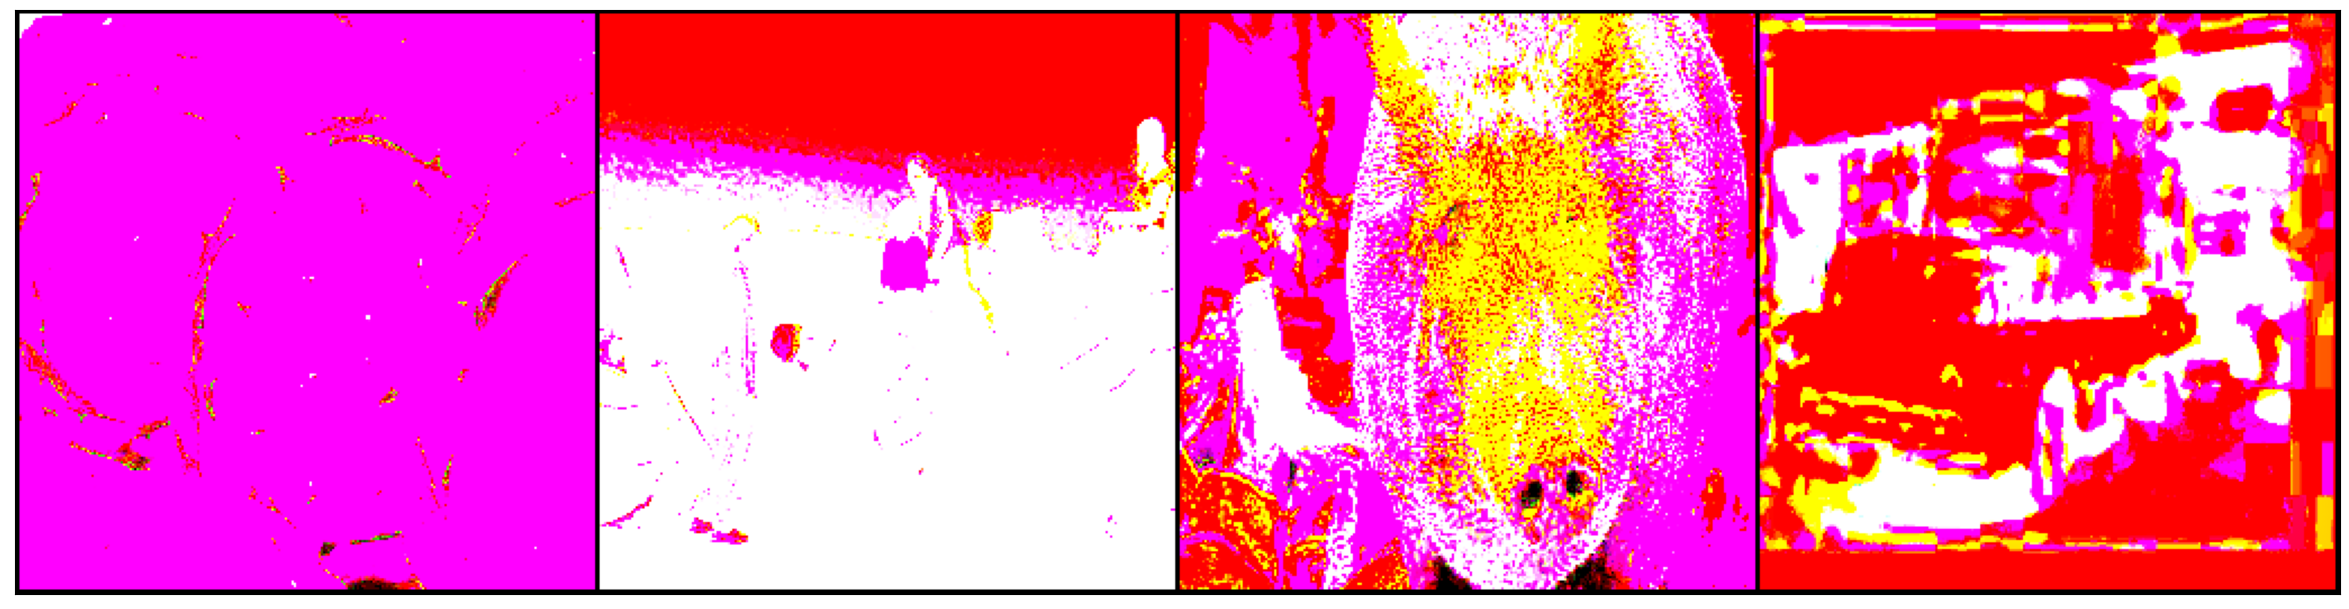

In [ ]:
show_batch(train_nogan)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

# Generator

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu"):
        """
        Block module for the generator network.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            down (bool): Flag indicating whether downsampling should be applied.
            act (str): Activation function to use ("relu" or "leaky").
        """
        super(Block, self).__init__()
        # Define convolutional layers with optional downsampling or upsampling
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False) if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2)
        )
        self.down = down

    def forward(self, x):
        """
        Forward pass of the block module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = self.conv(x)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels=1, features=64):
        """
        Generator network for image-to-image translation.

        Args:
            in_channels (int): Number of input channels (default: 1).
            features (int): Number of features in the network (default: 64).
        """
        super().__init__()
        # Initial downsampling layer
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
        )

        # Residual blocks
        self.res1 = nn.Sequential(
            nn.Conv2d(features, features, 3, 1, 1, bias=False),
            nn.BatchNorm2d(features),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features, features, 3, 1, 1, bias=False),
            nn.BatchNorm2d(features)
        )

        self.res2 = nn.Sequential(
            nn.Conv2d(features, features, 3, 1, 1, bias=False),
            nn.BatchNorm2d(features),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features, features, 3, 1, 1, bias=False),
            nn.BatchNorm2d(features)
        )

        # Downsample 1
        self.res3 = nn.Sequential(
            Block(features, features * 2, down=True, act="leaky"),
            nn.Conv2d(features * 2, features * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(features * 2)
        )
        self.downsample1 = nn.Sequential(
            nn.Conv2d(features, features * 2, 1, 2, bias=False),
            nn.BatchNorm2d(features * 2)
        )

        # Residual block
        self.res4 = nn.Sequential(
            nn.Conv2d(features * 2, features * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features * 2, features * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(features * 2)
        )

        # Downsample 2
        self.down2 = nn.Sequential(
            Block(features * 2, features * 4, down=True, act="leaky"),
            nn.Conv2d(features * 4, features * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(features * 4)
        )
        self.downsample2 = nn.Sequential(
            nn.Conv2d(features * 2, features * 4, 1, 2, bias=False),
            nn.BatchNorm2d(features * 4)
        )

        # Residual block
        self.res5 = nn.Sequential(
            nn.Conv2d(features * 4, features * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features * 4, features * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(features * 4)
        )

        # Downsample 3
        self.downsample3 = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 1, 2, bias=False),
            nn.BatchNorm2d(features * 8)
        )
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky")

        # Downsample 4
        self.downsample4 = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 1, 2, bias=False),
            nn.BatchNorm2d(features * 8)
        )
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky")

        # Downsample 5
        self.downsample5 = nn.Sequential(
            nn.Conv2d(features * 4, features * 8, 1, 2, bias=False),
            nn.BatchNorm2d(features * 8)
        )

        self.down5 = Block(features * 8, features * 8, down=True, act="leaky")
        self.down6 = Block(features * 8, features * 8, down=True, act="leaky")

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1),
            nn.ReLU()
        )

        # Upsampling blocks
        self.up1 = Block(features * 8, features * 8, down=False, act="relu")
        self.up2 = nn.Sequential(
            Block(features * 8 * 2, features * 8, down=False, act="relu"),
            nn.Dropout(0.5)
        )
        self.up3 = nn.Sequential(
            Block(features * 8 * 2, features * 8, down=False, act="relu"),
            nn.Dropout(0.5)
        )
        self.up4 = nn.Sequential(
            Block(features * 8 * 2, features * 8, down=False, act="relu"),
            nn.Dropout(0.5)
        )
        self.up5 = Block(features * 8 * 2, features * 4, down=False, act="relu")
        self.up6 = Block(features * 4 * 2, features * 2, down=False, act="relu")
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu")

        # Final output layer
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, 2, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        """
        Forward pass of the generator network.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        # Downsampling
        d1 = self.initial_down(x)
        d2 = self.res1(d1)
        d3 = self.res2(d2) + d1
        d4 = self.res3(d3) + self.downsample1(d3)  #downsample
        d5 = self.res4(d4) + d4  #downsample
        d6 = self.down2(d5) + self.downsample2(d5)
        d7 = self.res5(d6) + d6
        d8 = self.down3(d7) + self.downsample5(d7)
        d9 = self.down4(d8) + self.downsample3(d8)
        d10 = self.down5(d9)
        d11 = self.down6(d10) + self.downsample4(d10)
        # Bottleneck
        bottleneck = self.bottleneck(d11)
        # Upsampling blocks
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d11], 1))
        up3 = self.up3(torch.cat([up2, d10], 1))
        up4 = self.up4(torch.cat([up3, d9], 1))
        up5 = self.up5(torch.cat([up4, d8], 1))
        up6 = self.up6(torch.cat([up5, d7], 1))
        up7 = self.up7(torch.cat([up6, d5], 1))
        # Final output
        return self.final_up(torch.cat([up7, d3], 1))

In [ ]:
model = Generator(features=64)
model

Generator(
  (initial_down): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (res1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
from torchinfo import summary
summary(Generator(features=64), input_size=(4, 1, 256, 256))

# Model weight Initialization

In [ ]:
def init_weights(net, init='norm', gain=0.02):
    """
    Initialize the weights of a network.

    Args:
        net (nn.Module): The network to initialize.
        init (str): The type of weight initialization method. Options are 'norm', 'xavier', or 'kaiming'.
        gain (float): The std value to be used in weight initialization.

    Returns:
        nn.Module: The initialized network.
    """
    def init_func(m):
        classname = m.__class__.__name__

        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)

        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    # Apply weight initialization function to the network
    net.apply(init_func)
    print(f"Model initialized with {init} initialization")
    return net


def init_model(model, device):
    """
    Initialize a model and move it to a specified device.

    Args:
        model (nn.Module): The model to initialize.
        device (torch.device): The device to move the model to.

    Returns:
        nn.Module: The initialized and moved model.
    """
    # Move the model to the specified device
    model = model.to(device)
    # Initialize the weights of the model
    model = init_weights(model)
    return model


# Loss Function

## Feature Loss

The  below code implements a feature loss module for computing perceptual loss using the VGG19 network. Perceptual loss measures the difference between fake and real images by comparing their features extracted from different layers of the VGG19 network. The module takes in a list of weights for each feature loss layer as an argument. It initializes the VGG19 network, extracts feature slices from different layers, and computes the feature loss by comparing the features of the fake and real images. The feature loss is a weighted sum of the L1 loss between the feature representations.

In [ ]:
class FeatureLoss(nn.Module):
    """
    Feature loss module for computing perceptual loss using VGG19 network.

    Args:
        layer_wgts (list): List of weights for each feature loss layer (default: [20, 70, 10]).
    """

    def __init__(self, layer_wgts=[20, 70, 10]):
        super().__init__()

        # Load VGG19 network and extract feature slices
        vgg = models.vgg19_bn(weights='DEFAULT').features.cuda().eval()
        self.slice1 = vgg[:27]
        self.slice2 = vgg[27:40]
        self.slice3 = vgg[40:]

        self.wgts = layer_wgts
        self.base_loss = nn.L1Loss()
        self.loss = 0

        # Disable gradient computation for all parameters
        for p in self.parameters():
            p.requires_grad = False

    def features(self, x):
        """
        Extract feature slices from the input tensor.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            tuple: Feature slices from VGG19 network.
        """
        h1 = self.slice1(x)
        h2 = self.slice2(h1)
        h3 = self.slice3(h2)
        return h1, h2, h3

    def forward(self, fake, real):
        """
        Compute the feature loss between fake and real images.

        Args:
            fake (torch.Tensor): Fake image tensor.
            real (torch.Tensor): Real image tensor.

        Returns:
            torch.Tensor: The computed feature loss.
        """
        self.loss = 0  # Set loss to 0 before accumulating it
        fake_h1, fake_h2, fake_h3 = self.features(fake)
        real_h1, real_h2, real_h3 = self.features(real)

        # Compute feature loss for each layer and apply weights
        self.loss += self.base_loss(fake_h1, real_h1) * self.wgts[0]
        self.loss += self.base_loss(fake_h2, real_h2) * self.wgts[1]
        self.loss += self.base_loss(fake_h3, real_h3) * self.wgts[2]

        return self.loss


# N0 Gan LOSS calculation and Training

In [ ]:
class Nogan(nn.Module):
    """
    NoGAN model for image colorization.

    Args:
        net_G (nn.Module, optional): Pretrained generator network (default: None).
        lr_G (float): Learning rate for the generator network (default: 0.00011).
        lambda_L1 (float): Weight for the L1 loss (default: 100.0).
    """

    def __init__(self, net_G=None, lr_G=0.00011, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        # Initialize the generator network
        if net_G is None:
            self.net_G = to_device(init_weights(Generator(features=64)), device)
        else:
            self.net_G = to_device(net_G, device)

        # Define the L1 loss criterion
        self.L1criterion = nn.L1Loss().to(self.device)

        # Define the feature loss criterion
        self.feature_loss = FeatureLoss(layer_wgts=[30, 70, 10]).to(self.device)

        # Initialize the optimizer for the generator network
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G)

    def setup_input(self, data):
        """
        Set up input data for the model.

        Args:
            data (dict): Dictionary containing input data.
                - 'L' (torch.Tensor): L channel of the input image.
                - 'ab' (torch.Tensor): ab channels of the input image.
        """
        # Move input data to the device
        self.L = to_device(data['L'], device)
        self.ab = to_device(data['ab'], device)

    def forward(self):
        """
        Perform a forward pass through the generator network.
        """
        # Generate fake colorization from L channel
        self.fake_color = self.net_G(self.L)

    def backward_G(self):
        """
        Perform backward pass and compute generator loss.
        """
        # Compute L1 loss between fake colorization and ground truth ab channels
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1

        # Compute feature loss between input (L, fake_color) and target (L, ab)
        self.loss_G_feature = self.feature_loss(torch.cat([self.L, self.fake_color], dim=1),
                                                torch.cat([self.L, self.ab], dim=1))

        # Total generator loss
        self.loss = self.loss_G_L1 + self.loss_G_feature

        # Backpropagation
        self.loss.backward()

    def optimize(self):
        """
        Optimize the NoGAN model by updating the generator parameters.
        """
        # Perform forward pass and update generator
        self.forward()

        # Set the generator to training mode and zero the optimizer gradients
        self.net_G.train()
        self.opt_G.zero_grad()

        # Perform backward pass and update generator parameters
        self.backward_G()
        self.opt_G.step()


# Printing and visualization

In [ ]:
class AverageMeter:
    """
    Computes and stores the average and sum of values over time.
    """
    def __init__(self):
        self.reset()                   # Initialize the meter by calling the reset method

    def reset(self):
        """
        Resets the meter to its initial state.
        """
        self.count, self.avg, self.sum = [0.] * 3        # Set count, average, and sum to 0

    def update(self, val, count=1):
        """
        Updates the meter with a new value.

        Args:
            val (float): The new value to be added.
            count (int): The count associated with the new value (default: 1).
        """
        self.count += count         # Increment the count by the specified value (default is 1)
        self.sum += count * val     # Add the product of count and value to the sum
        self.avg = self.sum / self.count       # Calculate the average by dividing the sum by the count

def create_loss_meters_nogan():
    """
    Creates a dictionary of loss meters for non-GAN losses.

    Returns:
        dict: A dictionary with loss names as keys and AverageMeter objects as values.
    """
     # Create AverageMeter objects for tracking loss values
    loss_G_L1 = AverageMeter()        # Create an AverageMeter object to track the loss for the L1 loss component of the generator
    loss_G_feature = AverageMeter()   # Create an AverageMeter object to track the loss for the feature loss component of the generator
    loss = AverageMeter()             # Create an AverageMeter object to track the overall loss

    # Return a dictionary with loss names as keys and AverageMeter objects as values
    return {'loss_G_L1': loss_G_L1,
            'loss_G_feature': loss_G_feature,
            'loss': loss}

def update_losses(model, loss_meter_dict, count):
    """
    Updates the loss meters with the losses from the model.

    Args:
        model (MainModel): The model containing the losses.
        loss_meter_dict (dict): A dictionary of loss meters.
        count (int): The count associated with the losses.
    """
    # Iterate over each loss name and corresponding loss meter in the dictionary
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)                    # Get the loss value from the model using the loss name
        loss_meter.update(loss.item(), count=count)         # Update the loss meter with the loss value and count

def lab_to_rgb(L, ab):
    """
    Converts LAB color space to RGB color space.

    Args:
        L (tensor): L channel of LAB color space.
        ab (tensor): ab channels of LAB color space.

    Returns:
        ndarray: RGB images converted from LAB color space.
    """
    L = (L + 1.) * 50.   # Scale L channel to the range [0, 100]
    ab = ab * 128.       # Scale ab channels to the range [-128, 127]
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()     # Combine L and ab channels into a single tensor in LAB color space,
                                                                          # Permute dimensions to match the expected format for conversion, and
                                                                          # Convert the LAB color space tensor to a numpy array
    rgb_imgs = []        # Create an empty list to store the RGB images
    for img in Lab:      # Iterate over each image in the batch
        img_rgb = lab2rgb(img)          # Convert the LAB image to RGB color space
        rgb_imgs.append(img_rgb)        # Append the RGB image to the list
    return np.stack(rgb_imgs, axis=0)     # Convert the list of RGB images to a numpy array

def visualize(model, data, path, iteration, save=True):
    """
    Visualizes the model's outputs by converting them to RGB images.

    Args:
        model (MainModel): The model to visualize.
        data (dict): Input data for the model.
        path (str): Path to save the visualization images.
        iteration (int): Current iteration count.
        save (bool): Whether to save the visualization images (default: True).
    """
    model.net_G.eval()                    # Set the generator model to evaluation mode
    with torch.no_grad():                 # Disable gradient calculation and perform inference
        model.setup_input(data)           # Set up the input data for the model
        model.forward()                   # Forward pass through the model
    model.net_G.train()                   # Set the generator model back to training mode

    # Retrieve the generated color and real color from the model
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    # Convert the LAB color images to RGB color space
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    fig = plt.figure(figsize=(15, 8))             # Create a figure to display the images

    # Loop over 4 images in the batch
    for i in range(4):
      # Display the L channel image
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
         # Display the generated colorized image
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        # Display the real color image
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    # Show the figure
    plt.show()
    # Save the figure if save flag is True
    if save:
        fig.savefig(path + f"/colorization_{iteration}.png")


def log_results(loss_meter_dict):
    """
    Logs the average losses from the loss meters.

    Args:
        loss_meter_dict (dict): A dictionary of loss meters.
    """
    # Iterate over each loss name and corresponding loss meter in the dictionary
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")        # Print the loss name and the average value from the loss meter

# Creating Directories

Creating Directories for saving trained models and images saved during trainin

In [ ]:
!mkdir /kaggle/working/trained
!mkdir /kaggle/working/images
!mkdir /kaggle/working/ganimages

# Nogan training

In [ ]:
def train_model(model, train_dl, epochs, display_every=1562, iteration=1, epc=1):
    """
    Trains the model for the specified number of epochs.

    Args:
        model (object): The model to train.
        train_dl (torch.utils.data.DataLoader): DataLoader for training data.
        epochs (int): Number of training epochs.
        display_every (int, optional): Frequency of displaying losses during training. Default is 1562.
        iteration (int, optional): Initial iteration number. Default is 1.
        epc (int, optional): Epoch count. Default is 1.

    Returns:
        None
    """
    for e in range(epochs):
        loss_meter_dict = create_loss_meters_nogan()  # Create a dictionary to log the losses of the complete network

        # Iterate over the training data
        for i, data in tqdm(enumerate(train_dl, 1)):
            model.setup_input(data)  # Set up the input data for the model
            model.optimize()  # Optimize the model by performing a forward and backward pass
            update_losses(model, loss_meter_dict, count=data['L'].size(0))  # Update the loss meters

            # Print losses at specified intervals
            if iteration % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict)  # Print out the losses
                torch.save(model.net_G.state_dict(), f'/kaggle/working/trained/G_{e+1}_{iteration}_nogan.pth')

            # Visualize and save model outputs at specified intervals
            if iteration % 50000 == 0 or iteration == (320291 * epc):
                visualize(model, data, '/kaggle/working/ganimages', iteration, save=True)

            iteration += 1

        torch.save(model.net_G.state_dict(), f'/kaggle/working/trained/G_{e+1}_{iteration}_nogan.pth')  # Save model state at the end of each epoch


In [ ]:
# Loading of the Generator for resuming training
G = to_device(Generator(features=64),device)
G.load_state_dict(torch.load('/kaggle/input/pix2-9/G_1_325000_nogan.pth'))
model=to_device(Nogan(net_G=G,lr_G=0.0001),device)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

24999it [58:02,  7.20it/s]


Epoch 1/1
Iteration 25000/320292
loss_G_L1: 6.56713
loss_G_feature: 1.65680
loss: 8.22394


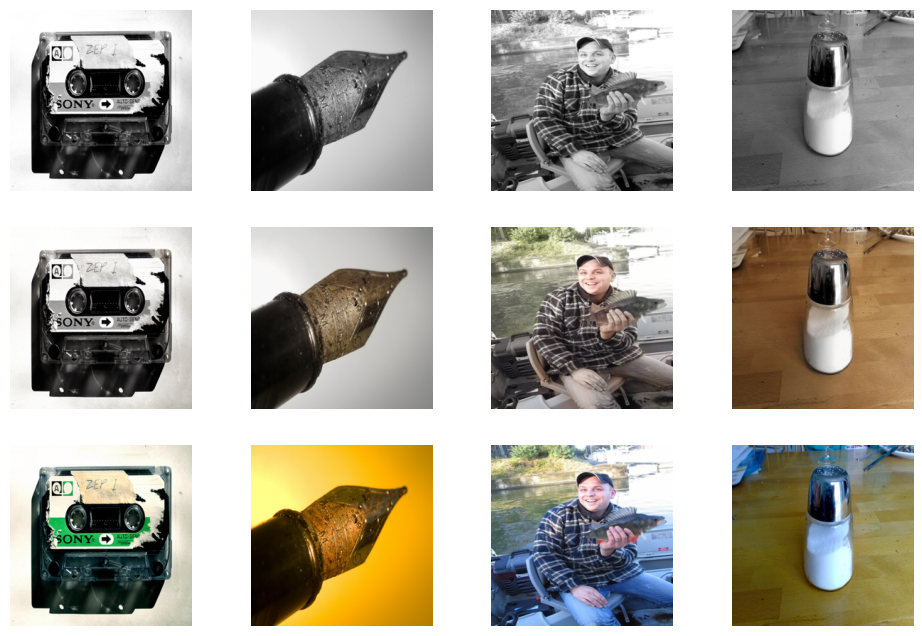

49999it [1:56:05,  7.36it/s]


Epoch 1/1
Iteration 50000/320292
loss_G_L1: 6.55782
loss_G_feature: 1.65331
loss: 8.21113


51131it [1:58:43,  7.18it/s]


KeyboardInterrupt: 

In [ ]:
train_model(model, train_nogan, 1,display_every=25000,epc=2,iteration=325001)